<a href="https://colab.research.google.com/github/jungmin0710/K-digital-PythonDeepLearning/blob/main/Variational_AutoEncoder_VAE_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational AutoEncoder(VAE)
* Representation Learning(표현 학습) 
  * 개념 벡터(Concept Vector) : 잠재공간(Latent Space)이나 임베딩(Embedding)이 주어 지면 이 공간의 어떤 방향은 원본데이터의 변화를 인코딩한 축일 수 있음. 
  * 개념 벡터의 연산으로 변형된 이미지를 복원(Decoding)하여 생성 가능
* Example
  * 원통의 '높이'와 '너비' 
    * 높이가 낮고 너비가 넓은 원통 이미지 생성
  * 눈의 '크기' 및 '색', 머리카락의 '길이' 및 '색' 
    * 긴 검은 머리에 갈색의 큰 눈을 가진 이미지 생성
* Decoder(Generator) 학습을 위해 Encoder 사용

In [1]:
import warnings 

warnings.filterwarnings('ignore')

## 0.Import Packages

In [2]:
import numpy as np 
import matplotlib.pyplot as plt

## 1.Load MNIST Dataset

### 1)X_train, X_test and y_train, y_test

In [3]:
from keras.datasets import mnist 

(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


### 2) Normalization and Reshape

In [4]:
X_train = X_train.astype('float32') / 255. 
X_test = X_test.astype('float32') / 255.

X_train = X_train.reshape(60000, 28 * 28) 
X_test = X_test.reshape(10000, 28 * 28)

X_train.shape, X_test.shape

((60000, 784), (10000, 784))

## 2.Keras Modeling with Functional API

### 1) 'Latent Space' Point Mapping
* 각 이미지가 '잠재공간(Latent Space) 포인트' 주변의 '다변수 정규 분포(Mutilvariate Nodrmal Distribution)'에 매핑

In [5]:
from keras.layers import Input, Dense 

input_img = Input(shape = (784,))

encoded = Dense(256, activation = 'elu')(input_img) 
encoded = Dense(128, activation = 'elu')(encoded)

* Variational(Latent Space) Layers 
  * 평균(mean)과 분산(log_var)으로 인코딩된 잠재공간(Latent Space) 포인트 분포

In [6]:
mean = Dense(2, name = 'mean')(encoded) 

log_var = Dense(2, name = 'var')(encoded)

### 2) 'Latent Space' Sampling
* 잠재공간(Latent Space)의 잠재공간-포인트(z) 샘플링 
  * 정규분포상에서 무작위로 선택한 'epsilon'값 사용 
    * Encoding 결과값을 그대로 사용하면 항상 같은 결과만 생성 
    * 따라서 랜덤 샘플링을 통하여 기존 Data에 존재하지 않는 새로운 Image 생성
* Lambda( ) : 임의의 파이썬 함수 객체를 Keras Layer로 생성 
* K.exp(log_var) : 로그분산 -> 표준편차 변환

In [9]:
from keras import backend as K 
from keras.layers import Lambda

def sampling(args):
  mean, log_var = args
  epsilon = K.random_normal(shape = (100, 2), mean = 0., stddev = 1.0) 
  return mean + K.exp(log_var) * epsilon
  
z = Lambda(sampling, output_shape = (2,))([mean, log_var])

### 3) 'encoder' Model

In [10]:
from keras.models import Model 

encoder = Model(input_img, mean)

* encoder Model Summary

In [11]:
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
mean (Dense)                 (None, 2)                 258       
Total params: 234,114
Trainable params: 234,114
Non-trainable params: 0
_________________________________________________________________


### 4) 'generator' Model
* Decoding Layer Structure

In [12]:
decoder_1 = Dense(128, activation = 'elu') 
decoder_2 = Dense(256, activation = 'elu') 
decoder_3 = Dense(784, activation = 'sigmoid')

* 랜덤 샘플링 '잠재공간-포인트(Z)' 재구성

In [13]:
z_sample = decoder_1(z) 
z_sample = decoder_2(z_sample) 
z_sample = decoder_3(z_sample)

In [14]:
z_sample.shape

TensorShape([100, 784])

* Generator Layers

In [15]:
decoder_input = Input(shape = (2,))

y_gen = decoder_1(decoder_input) 
y_gen = decoder_2(y_gen) 
y_gen = decoder_3(y_gen)

* Build 'generator'

In [16]:
generator = Model(decoder_input, y_gen)

* 'generator' Model Summary

In [17]:
generator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              multiple                  384       
_________________________________________________________________
dense_3 (Dense)              multiple                  33024     
_________________________________________________________________
dense_4 (Dense)              multiple                  201488    
Total params: 234,896
Trainable params: 234,896
Non-trainable params: 0
_________________________________________________________________


## 3.VAE Fit

### 1) 'vae' Model Define
* Build 'vae' Model 
  * End-to-End AutoEncoder

In [18]:
vae = Model(input_img, z_sample)

* 'vae' Model Summary

In [19]:
vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          32896       dense[0][0]                      
__________________________________________________________________________________________________
mean (Dense)                    (None, 2)            258         dense_1[0][0]                    
____________________________________________________________________________________________

### 2) Model Compile
* Define 'vae_loss'
  * reconstruction_loss : 입력값 재구성 손실
원본 이미지와 생성된 이미지와의 오차(CEE) 
  * '샘플링 함수'로 생성한 'z' 값으로 얼마나 원본이미지와 유사한 이미지를 잘 생성 하는가?

  * kl_loss : 사전 분포와 잠재 분포 사이의 Kullback Leibler-Divergence(두 확률분포 간 거 리)

    * 사전 분포(Prior Distribution) : 원본 이미지 확률분포
    * 잠재 분포(Latent Distribution) : 잠재공간 확률분포 
    * '샘플링 함수'의 값이 원본 이미지의 확률분포와 유사한가?
* 추가 설명

In [20]:
from keras import objectives

reconstruction_loss = objectives.binary_crossentropy(input_img, z_sample) 
kl_loss = 0.0005 * K.mean(K.square(mean) + K.exp(log_var) - log_var - 1, axis = -1)

vae_loss = reconstruction_loss + kl_loss

* Add vae_loss

In [21]:
vae.add_loss(vae_loss)

* Compile with vae_loss

In [24]:
vae.compile(optimizer = 'adam')

### 3) Model Training

In [25]:
%%time

vae.fit(X_train, 
        shuffle = True, 
        epochs = 300, 
        batch_size = 100,
        validation_data = (X_test, None))

Epoch 1/300
600/600 [==============================] - 5s 4ms/step - loss: 0.2735 - val_loss: 0.2167
Epoch 2/300
600/600 [==============================] - 2s 4ms/step - loss: 0.2166 - val_loss: 0.2087
Epoch 3/300
600/600 [==============================] - 2s 4ms/step - loss: 0.2065 - val_loss: 0.2024
Epoch 4/300
600/600 [==============================] - 2s 4ms/step - loss: 0.2010 - val_loss: 0.1980
Epoch 5/300
600/600 [==============================] - 2s 4ms/step - loss: 0.1960 - val_loss: 0.1939
Epoch 6/300
600/600 [==============================] - 2s 4ms/step - loss: 0.1923 - val_loss: 0.1901
Epoch 7/300
600/600 [==============================] - 2s 4ms/step - loss: 0.1892 - val_loss: 0.1881
Epoch 8/300
600/600 [==============================] - 2s 4ms/step - loss: 0.1873 - val_loss: 0.1864
Epoch 9/300
600/600 [==============================] - 2s 4ms/step - loss: 0.1855 - val_loss: 0.1849
Epoch 10/300
600/600 [==============================] - 2s 4ms/step - loss: 0.1841 - val_lo

## 4.'Latent Space' Visualization

### 1) Classes in the Latent Space

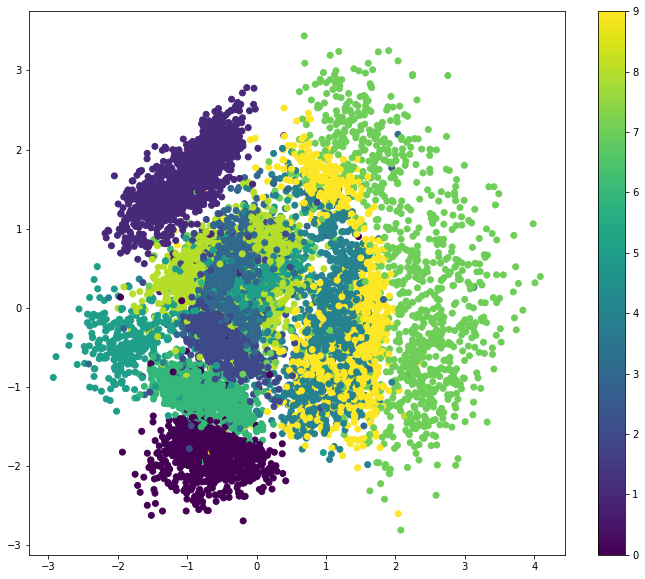

In [27]:
X_test_latent = encoder.predict(X_test, batch_size = 100) 

plt.figure(figsize = (12, 10)) 
plt.scatter(X_test_latent[:, 0], X_test_latent[:, 1], c = y_test) 
plt.colorbar() 
plt.show()

### 2) Display 2D Manifold(20 * 20)
* 두 개의 '개념 벡터(Concept Vector)'로 데이터의 특징을 '표현(Representation)' 
  * 두께, 회전각도 등

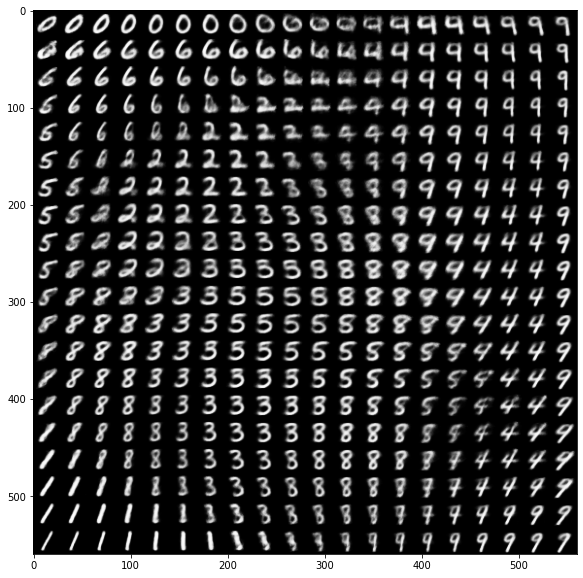

In [28]:
from scipy.stats import norm

n = 20
digit_size = 28 
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) 
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x): 
  for j, xi in enumerate(grid_y): 
    z_sample = np.array([[xi, yi]]) 
    x_decoded = generator.predict(z_sample) 
    digit = x_decoded[0].reshape(digit_size, digit_size) 
    figure[i * digit_size: (i + 1) * digit_size, 
           j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize = (10, 10)) 
plt.imshow(figure, cmap = 'Greys_r') 
plt.show()

## 5.'generator' Test

### 1) 'encoder' Test (784 -> 2)

In [29]:
encoded_latent = encoder.predict(X_test) 

encoded_latent.shape

(10000, 2)

### 2) 'generator' Test (2 -> 784)

In [30]:
generated_imgs = generator.predict(encoded_latent) 

generated_imgs.shape

(10000, 784)

### 3) Generating Visualization
* 복원이 아닌 생성된 이미지들

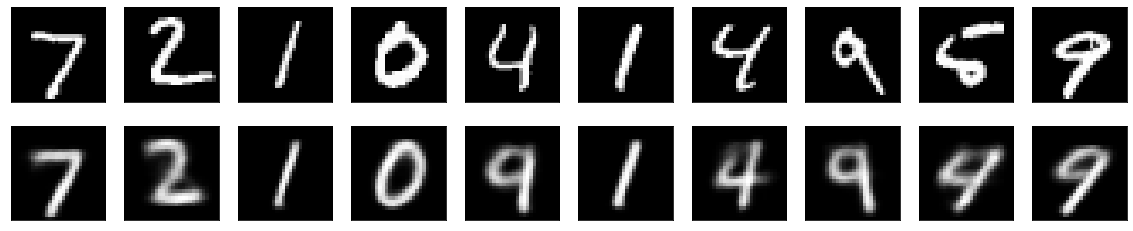

In [31]:
n = 10

plt.figure(figsize = (20, 4)) 

for i in range(n):
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(X_test[i].reshape(28, 28)) 
  plt.gray()
  
  ax.get_xaxis().set_visible(False) 
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, n, i + 1 + n) 
  plt.imshow(generated_imgs[i].reshape(28, 28)) 
  plt.gray()

  ax.get_xaxis().set_visible(False) 
  ax.get_yaxis().set_visible(False)

plt.show()

본 내용은 2021/03/29(월)에 학습한 내용입니다.